# Introduction to Graph Neural Networks with PyTorch

# HOMEWORK 7

Perform node classification on the PubMed dataset to classify scientific publications into their respective categories. The PubMed dataset is a citation network among scientific publications. It consists of articles related to diabetes, with each article belonging to one of three categories: "Diabetes Mellitus Type 1" (class 0), "Diabetes Mellitus Type 2" (class 1), and "Diabetes Mellitus" (class 2).

# Install required packages.


In [1]:
import os
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2.1.2+cu121


# Load the dataset

In [2]:
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
from torch_geometric.datasets import Planetoid

# Load the Cora dataset
dataset = Planetoid(root='data/Planetoid', name='PubMed', split='full')

# Print dataset information
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0].to(device)  # Get the first graph object.

train, val, test = data.train_mask, data.val_mask, data.test_mask

print()
print(data)


Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


**Define a GCN network**

The following takes a list of hidden layer sizes and corresponding dropout layers probabilities as arguments. This is to make it flexible so that the tuning later will be simpler.

In [26]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_layers=[50, 20], drop=[0.5, 0.5]) -> None:
        super().__init__()
        torch.manual_seed(3)
        self.convs = torch.nn.ModuleList()
        try:
            len(drop)
            self.drop = drop
        except:
            self.drop = [drop]*len(hidden_layers)
        self.convs.append(GCNConv(dataset.num_features, hidden_layers[0]))
        for i in range(1, len(hidden_layers)):
            self.convs.append(GCNConv(hidden_layers[i-1], hidden_layers[i]))
        self.final = GCNConv(hidden_layers[-1], dataset.num_classes)

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = F.relu(conv(x, edge_index))
            x = F.dropout(x, p=self.drop[i], training=self.training)

        x = self.final(x, edge_index)
        return x

model = GCN().to(device)
print(model)

GCN(
  (convs): ModuleList(
    (0): GCNConv(500, 50)
    (1): GCNConv(50, 20)
  )
  (final): GCNConv(20, 3)
)


**Visualize the node embeddings of the untrained GCN network using PCA (or t-SNE if you are or want to get familiar with it)**

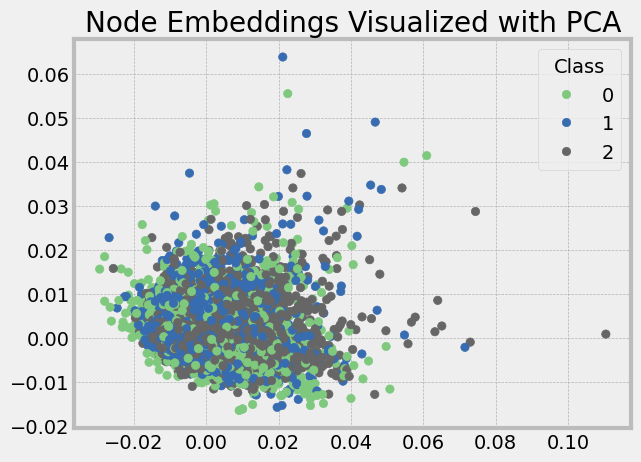

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.style.use('bmh')

model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).detach().cpu().numpy()

pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=data.y.cpu(), cmap='Accent')
plt.legend(*scatter.legend_elements(), loc='upper right', title='Class')
plt.title('Node Embeddings Visualized with PCA')
plt.show()

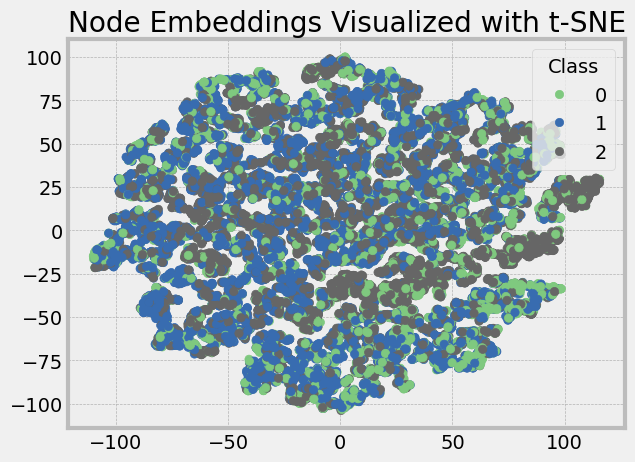

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
embeddings_tsne = tsne.fit_transform(embeddings)

scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=data.y.cpu(), cmap='Accent')
plt.legend(*scatter.legend_elements(), loc='upper right', title='Class')
plt.title('Node Embeddings Visualized with t-SNE')
plt.show()

We can see that in both projection methods, there doen't appear to be any pattern or structure, the placements are random as expected. We will hope that this will change once the model is trained.

**Perform a grid search hyperparameter tuning for the following parameters:**
- Number of Layers
- Hidden Dimension Size
- Learning Rate
- Dropout Rate
- Batch Size

PS: Remember, first you need to split the data into training, validation and test sets.

The split doesn't have to be made explicitly, we use the masks as given by the dataset itself in order to index the set we need in each case.

Training auxiliary functions:

In [23]:
from tqdm.notebook import tqdm, trange
import torch.optim as optim
import torch.nn as nn
import numpy as np

def evaluate(model, mask, loss):
    model.eval()

    with torch.no_grad():
        model.to(device)
        out = model(data.x, data.edge_index)
        l = loss(out[mask], data.y[mask])
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.y[mask]
        acc = correct.sum().item() / mask.sum().item()

    return acc, l.item()


def plot_results(train_accs, valid_accs, train_losses, valid_losses):
    n_epochs = len(train_accs)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

    ax[0].plot(train_losses, label='train')
    ax[0].plot(valid_losses, label='validation')
    ax[0].set_title('Loss')
    ax[0].legend()

    ax[1].plot(train_accs, label='train')
    ax[1].plot(valid_accs, label='validation')
    ax[1].set_title('Accuracy')
    ax[1].legend()

    ax[1].set_xlabel('Epoch')
    ax[1].set_xlim(0, n_epochs-1)

    plt.show()


def train_model(model, n_epochs=6, lr=1e-3, optimizer=None, loss=None, earlystop_window=20, plot=True, verbose=True, bar=True):
    train_accs, valid_accs = [], []
    train_losses, valid_losses = [], []

    model = model.to(device)
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=lr)
    if loss is None:
        loss = nn.CrossEntropyLoss()

    if bar:
        epochs = trange(n_epochs)
    else:
        epochs = range(n_epochs)

    best_val_acc = 0
    best_val_loss = np.inf
    best_epoch = 0
    best_state = model.state_dict()

    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        l = loss(out[train], data.y[train])
        l.backward()
        optimizer.step()

        train_acc, train_loss = evaluate(model, train, loss)
        valid_acc, valid_loss = evaluate(model, val, loss)

        if valid_acc > best_val_acc or valid_loss < best_val_loss:
            best_epoch = epoch
            best_val_acc = max(valid_acc, best_val_acc)
            best_val_loss = min(valid_loss, best_val_loss)
            best_state = model.state_dict()
        else:
            if epoch - best_epoch > earlystop_window:
                if verbose:
                    print(f"Early stopping at epoch {epoch+1}")
                break

        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if verbose:
            print(f"Epoch {epoch+1:02d}:", end=' ')
            print(f"train accuracy = {train_accs[epoch]:.4f} | validation accuracy = {valid_accs[epoch]:.4f}")

    if plot:
        plot_results(train_accs, valid_accs, train_losses, valid_losses)

    torch.save(best_state, 'best_model.pth')
    if verbose:
        print(f"Best validation accuracy: {best_val_acc:.4f} | Best validation loss: {best_val_loss:.4f}")
        print(f"Model state at epoch {best_epoch} saved to 'best_model.pth'")

    return (train_accs, valid_accs), (train_losses, valid_losses), best_state

Note: batch size is not relevant here I think, from what I understood it is used inter-graph (for batching separate graphs) and not intra-graph (for batching separate nodes from the same graph) in torch-geometric.

In [58]:
from sklearn.model_selection import ParameterGrid

LR = np.linspace(1e-3, 1e-2, 4)
L2 = np.linspace(1e-5, 1e-2, 4)
dropout = [0.3, 0.6]
hid = [[50], [50, 20], [100], [100, 50], [200], [200, 100], [50, 20, 10]]

param_grid = {
    'lr': LR,
    'l2': L2,
    'dropout': dropout
}

grid = ParameterGrid(param_grid)
best_acc = 0
best_params = None
best_idx = None
best_state = None

for i in trange(len(hid)):
    print(f"\nHidden layers: {hid[i]}")
    for params in grid:
        lr = params['lr']
        l2 = params['l2']
        drop = params['dropout']

        model = GCN(hidden_layers=hid[i], drop=drop)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
        (train_accs, valid_accs), _, state = train_model(model, n_epochs=1000, lr=lr, optimizer=optimizer, plot=False, verbose=False, bar=False)

        if valid_accs[-1] > best_acc:
            best_acc = valid_accs[-1]
            best_params = params
            best_idx = i
            best_state = state

print(f"Best validation accuracy: {best_acc:.4f}")
print(f"Best hidden layers: {hid[best_idx]}")
print(f"Best parameters: {best_params}")

Best validation accuracy: 0.9
Best hidden layers: [100]
Best parameters: {'lr': 0.001, 'l2': 1e-05, 'dropout': 0.3}


We can see that a simple model with only a single hidden layer appears to maximise results, while there is no big need for regularization to avoid overfitting, since both l2 factor and dropout rate are on the low end of the search space.

**Train the GCN model with the optimal hyperparameters**
 - Select the best model based on the highest validation performance (lowest validation loss).*italicized text*
 - Save the best model to load it later for the final evaluation process.

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 01: train accuracy = 0.6302 | validation accuracy = 0.6340
Epoch 02: train accuracy = 0.6403 | validation accuracy = 0.6360
Epoch 03: train accuracy = 0.6421 | validation accuracy = 0.6380
Epoch 04: train accuracy = 0.6481 | validation accuracy = 0.6620
Epoch 05: train accuracy = 0.6539 | validation accuracy = 0.6660
Epoch 06: train accuracy = 0.6651 | validation accuracy = 0.6680
Epoch 07: train accuracy = 0.6917 | validation accuracy = 0.7020
Epoch 08: train accuracy = 0.7293 | validation accuracy = 0.7520
Epoch 09: train accuracy = 0.7615 | validation accuracy = 0.7720
Epoch 10: train accuracy = 0.7823 | validation accuracy = 0.7880
Epoch 11: train accuracy = 0.7925 | validation accuracy = 0.8040
Epoch 12: train accuracy = 0.8008 | validation accuracy = 0.8140
Epoch 13: train accuracy = 0.8070 | validation accuracy = 0.8240
Epoch 14: train accuracy = 0.8096 | validation accuracy = 0.8360
Epoch 15: train accuracy = 0.8146 | validation accuracy = 0.8380
Epoch 16: train accuracy 

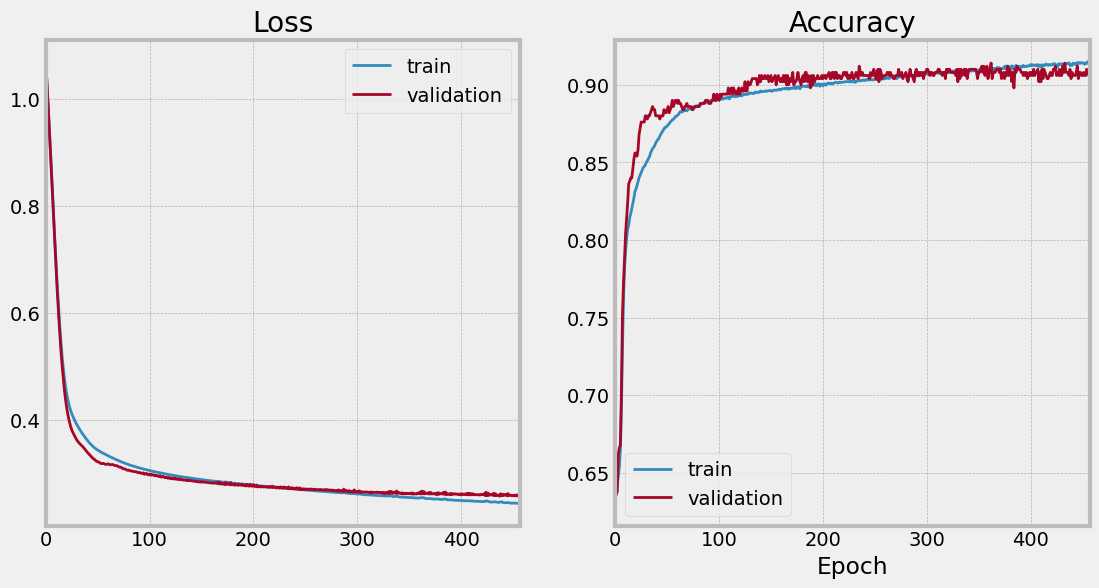

Best validation accuracy: 0.9140 | Best validation loss: 0.2577
Model state at epoch 437 saved to 'best_model.pth'


In [63]:
model = GCN(hidden_layers=[100], drop=[0.2])

lr=0.01
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-5)

train_model(model, n_epochs=1000, lr=lr, optimizer=optimizer);

After a bit of experimenting, the above model appears to be the best one, different to the one from the grid search result only subtly: slightly increased L2 regularisation and slightly decreased dropout rate, which seemed to be a better balance to avoid overfitting while maximising performance as measured in validation accuracy.

**Visualize the output embeddings of your trained model. What do you observe?**

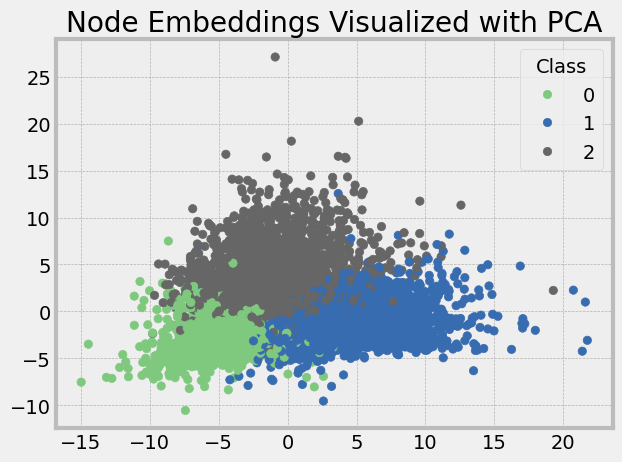

In [17]:
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).detach().cpu().numpy()

pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=data.y.cpu(), cmap='Accent')
plt.legend(*scatter.legend_elements(), loc='upper right', title='Class')
plt.title('Node Embeddings Visualized with PCA')
plt.show()

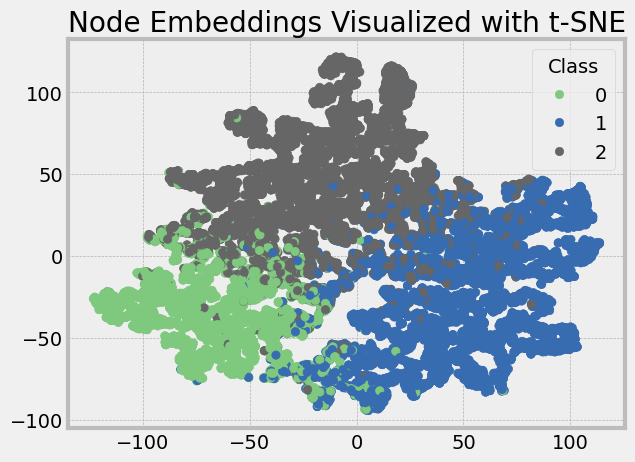

In [18]:
embeddings_tsne = tsne.fit_transform(embeddings)

scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=data.y.cpu(), cmap='Accent')
plt.legend(*scatter.legend_elements(), loc='upper right', title='Class')
plt.title('Node Embeddings Visualized with t-SNE')
plt.show()

With both projection methods, it's clear that as a result of training, (the projections of) the embeddings are more separated and the clusters are more distinct. This is a good sign of model performance. Even though there's still some overlap, we're probably near the best we can do given the data and the type of model.

**Evaluate the trained model on the test set and report the classification accuracy**

In [64]:
model.load_state_dict(torch.load('best_model.pth'))
test_acc, _ = evaluate(model, test, nn.CrossEntropyLoss())
print(f'Test set accuracy: {test_acc}')

Test set accuracy: 0.894
